# Cleaning Modes With Rational Filters

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as pl
import numpy as np
import qnm_filter
from gwpy.timeseries import TimeSeries
import copy
from scipy.interpolate import interp1d
from scipy.interpolate import splev, splrep
from scipy.special import logsumexp

In [3]:
theoretical_values = (68.6, 0.71) #mass and spin of the final black hole

## Data

Download data

In [4]:
home_dir = "./MDC_waveforms/"

In [5]:
H_filename = "H-H1_NR_INJECTED-1126259448-16_TEOBResumS_GR_q_0.8_chi1_0.1_chi2_0.1_M72_dist452_incl1p59_ra1p68_decm1p27_psi3p93_flow7_nonoise_aligned.gwf"
L_filename = "L-L1_NR_INJECTED-1126259448-16_TEOBResumS_GR_q_0.8_chi1_0.1_chi2_0.1_M72_dist452_incl1p59_ra1p68_decm1p27_psi3p93_flow7_nonoise_aligned.gwf"

In [6]:
H_data = TimeSeries.read(home_dir + H_filename, 'H1:NR_INJECTED')
L_data = TimeSeries.read(home_dir + L_filename, 'L1:NR_INJECTED')

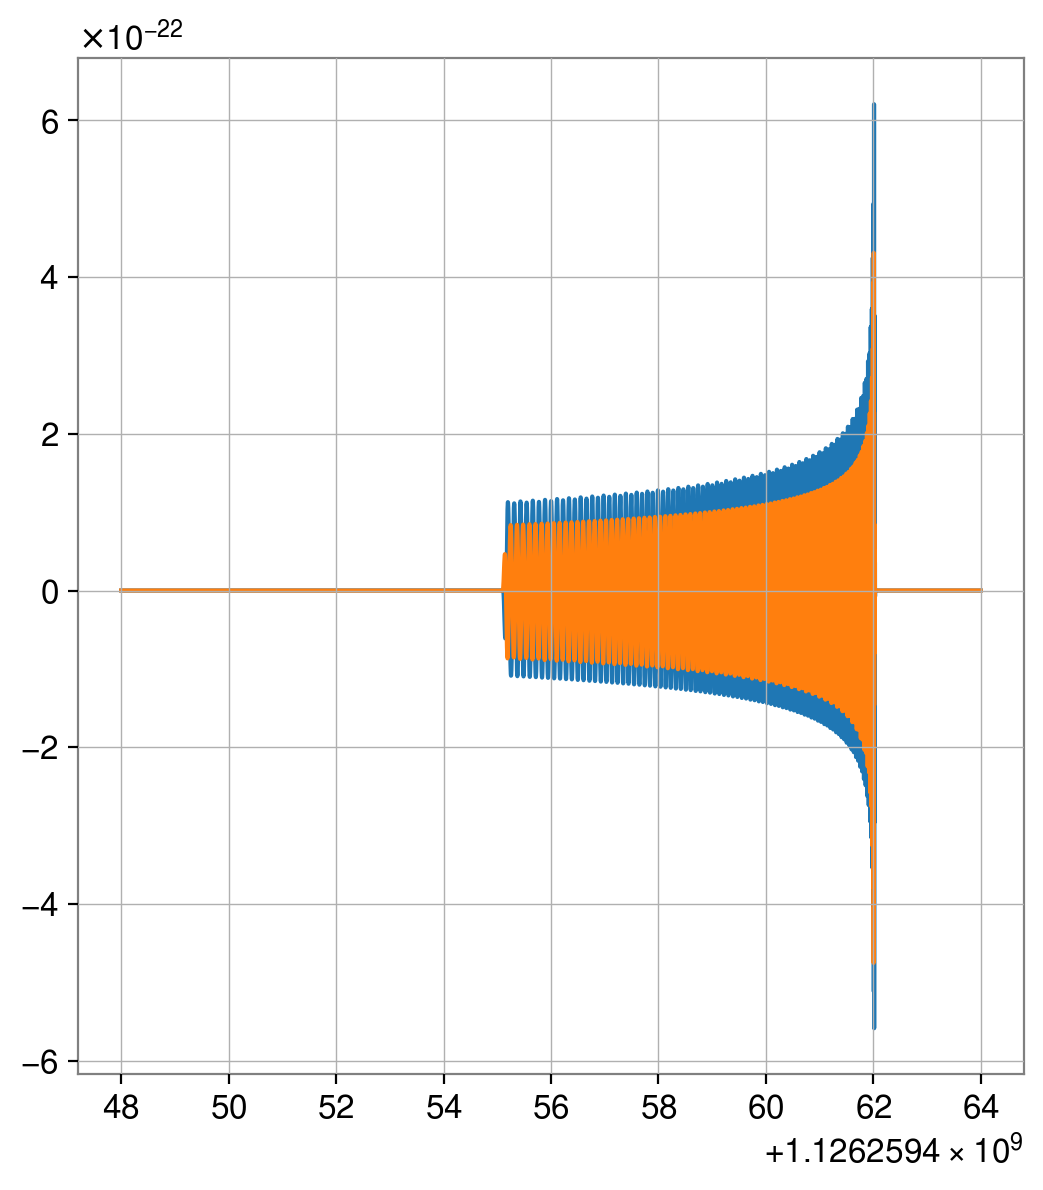

In [46]:
pl.plot(H_data)
pl.plot(L_data)

In [54]:
H_waveform = qnm_filter.Data(H_data.value, index = H_data.times.value)
L_waveform = qnm_filter.Data(L_data.value, index = L_data.times.value)

In [9]:
peak_time = H_data.times.value[np.argmax(H_waveform)]
SSB_peak_time = peak_time - 0.014685396838313368

In [10]:
SSB_peak_time

1126259461.9987423

In [11]:
asd = np.loadtxt('./LIGO-asd.txt')

In [12]:
asd_freqs = asd[:,0]
asd_amps = asd[:,1]
asd_interp = interp1d(asd_freqs, asd_amps)
freq_space = np.linspace(asd_freqs[0], asd_freqs[0]+2048, 2048*2)

In [13]:
# np.savetxt('resampled_asd.txt', np.c_[(freq_space, asd_interp(freq_space))])

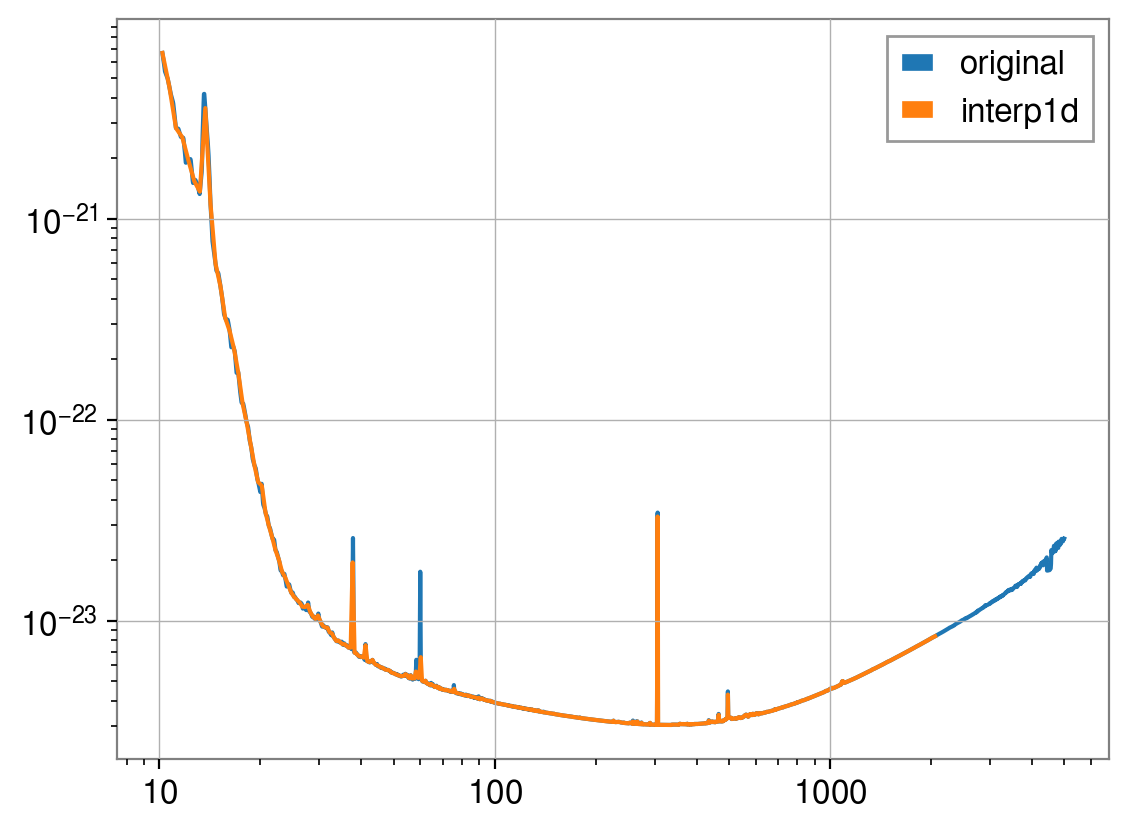

In [14]:
pl.loglog(asd_freqs, asd_amps, label = 'original')
pl.loglog(freq_space, asd_interp(freq_space), label = 'interp1d')
# pl.loglog(freq_space, y2, label = 'spline')
pl.legend()

## Filter

In [47]:
mass_unit = qnm_filter.Filter.mass_unit(theoretical_values[0])

In [48]:
input = dict(model_list = [(2,2,0),(2,1,0)], #l, m, n
             # trucation time (geocenter, in second)
             t_init = SSB_peak_time+10*mass_unit, #Calculated from SNR+t_init notebook
             # length of the analysis window (in second)
             window_width = 0.2,
             # sampling rate after conditioning (in Hz)
             srate = 4096,
             # sky localization
             ra = 1.95, dec = -1.27,
             # lower limit of the high-pass filter (in Hz)
             flow = 20)

fit = qnm_filter.Network(**input)

Load data

In [49]:
fit.original_data['H1'] = 1.5*H_waveform
fit.original_data['L1'] = 1.5*L_waveform

In [50]:
fit.detector_alignment()
fit.condition_data('original_data', **input, trim = 0.0)
fit.compute_acfs('original_data')

AttributeError: 'Series' object has no attribute 'time'

In [ ]:
fit.pure_noise = {}
fit.pure_noise['H1'] = qnm_filter.Noise('asd')
fit.pure_noise['H1'].load_noise_curve('asd', './resampled_asd.txt')
fit.pure_noise['H1'].from_asd()
fit.pure_noise['L1'] = qnm_filter.Noise('asd')
fit.pure_noise['L1'].load_noise_curve('asd', './resampled_asd.txt')
fit.pure_noise['L1'].from_asd()

In [51]:
fit.acfs['H1'] = qnm_filter.Data(fit.pure_noise['H1'].acf)
fit.acfs['L1'] = qnm_filter.Data(fit.pure_noise['L1'].acf)

AttributeError: 'Network' object has no attribute 'pure_noise'

In [52]:
fit.cholesky_decomposition()

In [38]:
fit.first_index()
template = fit.truncate_data(fit.original_data)['H1']

In [39]:
fit.compute_SNR(0, template, 'H1', optimal=True)

7.578605382149634

In [40]:
delta_mass = 1.0
delta_chi = 0.05
massspace = np.arange(34, 140, delta_mass)
chispace = np.arange(0.0, 0.95, delta_chi)
mass_grid, chi_grid = np.meshgrid(massspace, chispace)

In [41]:
fit.first_index()
likelihood_data, evidence = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 9, **input)
credible_region = qnm_filter.find_credible_region(likelihood_data)

/home/neil/anaconda3/envs/ringdown/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [42]:
credible_region = qnm_filter.find_credible_region(likelihood_data, target_probability=0.9)

In [43]:
projected_mass, projected_chi = qnm_filter.project_to_1d(likelihood_data, delta_mass, delta_chi)

In [44]:
filters_str = '+'.join([''.join(str(i) for i in j) for j in input['model_list']])
time_str = str(np.round((input['t_init'] - SSB_peak_time)/mass_unit, 2))

Text(105, 0.1, 'ln(evidence) = 4.38')

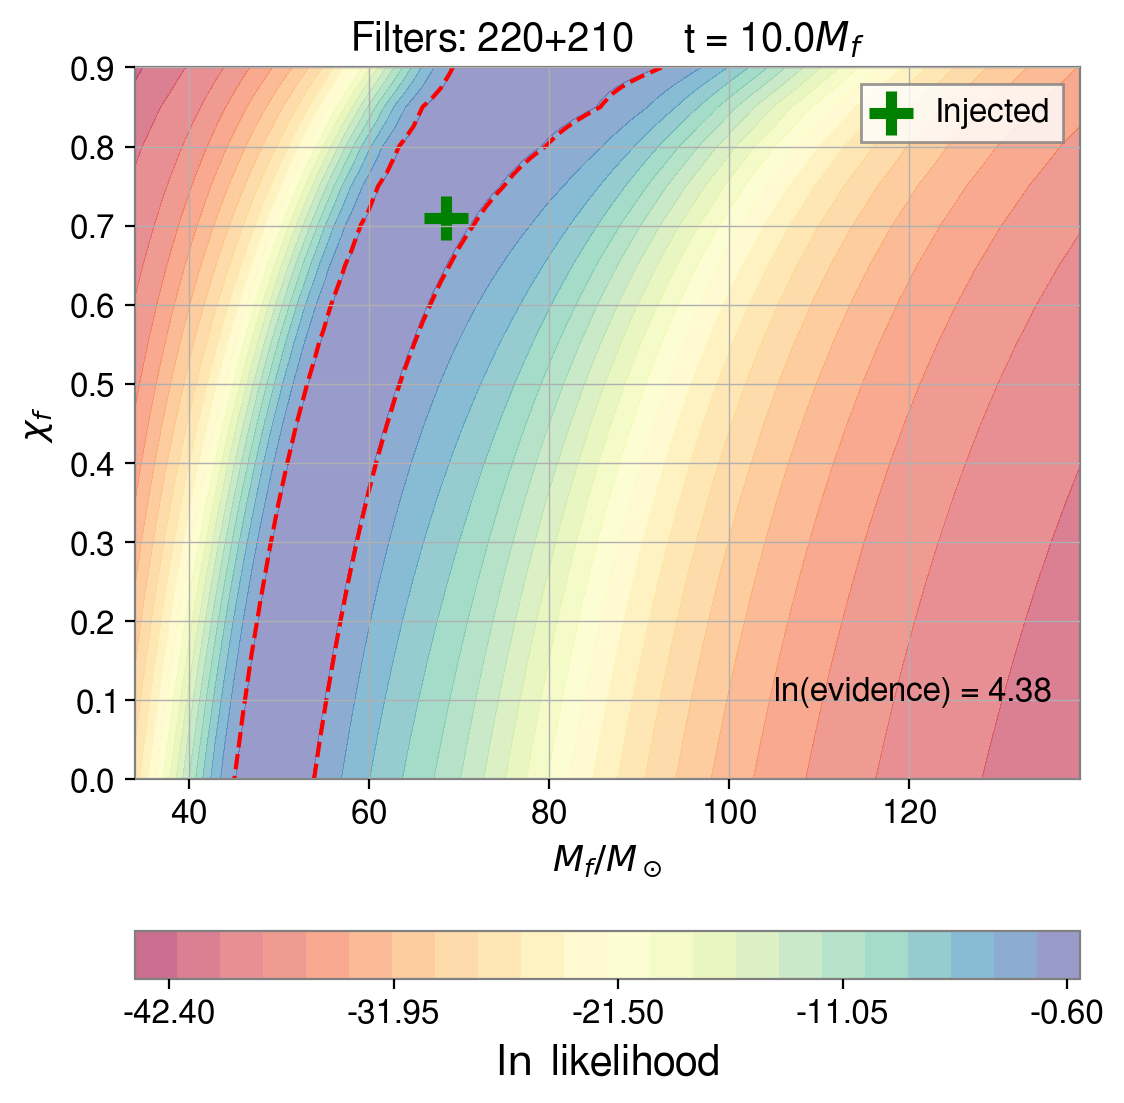

In [45]:
pl.rc('figure', figsize=(6.1, 6.6))
fig, ax = pl.subplots()
contours = ax.contourf(mass_grid, chi_grid, likelihood_data, 20, cmap='Spectral',
                       origin='lower', alpha=0.6, linestyles='--')
dotted = ax.contour(mass_grid, chi_grid, likelihood_data, [credible_region], colors = 'red', \
                   linestyles ='--')
ax.scatter(x=theoretical_values[0], y=theoretical_values[1], s=255, marker='+', 
           c='g', linewidths=4, label='Injected')
# ax.scatter(x=average_mass, y=average_chi, s=255, marker='+', 
#            c='r', linewidths=4, label='weighted average')
# ax.scatter(x=MAP_value[0], y=MAP_value[1], s=255, marker='+', 
#            c='y', linewidths=4, label='MAP')


# coloarbar
cbar=fig.colorbar(contours, orientation="horizontal", 
                  pad=0.15, format='%3.2f')
cbar.set_label(r'$\ln$ likelihood', fontsize=15)
cbar.set_ticks(np.linspace(np.min(likelihood_data), np.max(likelihood_data), 5))

pl.xlabel(r'$M_f/M_\odot$', fontsize=13)
pl.ylabel(r'$\chi_f$', fontsize=13)
pl.legend()
ax.set_title("Filters: " + filters_str + "     t = " + time_str + r'$M_f$')
ax.text(105, 0.1, 'ln(evidence) = %.2f' % logsumexp(likelihood_data))
# ax.text(118, 0.1, '$\epsilon_{MAP} = %.2f$' '\n' '$\epsilon_{avg} = %.2f$' % (MAP_epsilon, average_epsilon))